In [5]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

In [ ]:
# Configuration
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"
HF_TOKEN = "your_huggingface_token_here"
CSV_PATH = "data/formality_prompts.csv"
DATASET_SIZE = 40
MAX_LENGTH = 256  # Shorter for speed
DEVICE = "cuda"

torch.set_grad_enabled(False)

In [4]:
# Load model with optimizations
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    token=HF_TOKEN,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0"  # Force single GPU
)

print("Model loaded successfully")

Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
2025-09-28 19:31:42.167678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759087902.249544    8122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759087902.277550    8122 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759087902.440891    8122 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759087902.440913    8122 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759087902.440915    8122

Model loaded successfully


In [39]:
# for each topic, there are 2 prompts with the same token length,
# each prompt stands for a epistemic status: certain or uncertain
df = pd.read_csv(CSV_PATH)

In [40]:
df

,topic,formality_status,prompt
0,python_help,formal,Could you please explain how Python functions ...
1,python_help,informal,Could you just explain how Python functions wo...
2,climate_change,formal,I would appreciate your analysis of climate ch...
3,climate_change,informal,I would appreciate your analysis of climate ch...
4,cooking_advice,formal,Would you kindly recommend healthy meal prepar...
...,...,...,...
79,digital_security,informal,I should appreciate guidance about online priv...
80,creative_problem_solving,formal,Could you please explain innovative thinking t...
81,creative_problem_solving,informal,Could you maybe explain innovative thinking te...
82,emotional_intelligence,formal,Would you kindly discuss emotional awareness s...


In [41]:
# Group by topic to get pairs
# Before experimet, double-check each pair of prompts has the same length of tokens
topics = df['topic'].unique()
mismatches = []

for topic in topics:
    topic_data = df[df['topic'] == topic]
    formal_prompt = topic_data[topic_data['formality_status'] == 'formal']['prompt'].iloc[0]
    informal_prompt = topic_data[topic_data['formality_status'] == 'informal']['prompt'].iloc[0]
    
    formal_tokens = len(tokenizer.encode(formal_prompt))
    informal_tokens = len(tokenizer.encode(informal_prompt))
    
    if formal_tokens != informal_tokens:
        mismatches.append({
            'topic': topic,
            'certain_tokens': formal_tokens,
            'uncertain_tokens': informal_tokens,
            'difference': abs(formal_tokens - informal_tokens)
        })
        print(f"❌ {topic}: {formal_tokens} vs {informal_tokens}")
    else:
        print(f"✅ {topic}: {formal_tokens} tokens")

if mismatches:
    print(f"\n⚠️  Found {len(mismatches)} mismatched pairs!")
else:
    print(f"\n🎉 All {len(topics)} pairs are token-matched!")

✅ python_help: 15 tokens
✅ climate_change: 15 tokens
✅ cooking_advice: 20 tokens
✅ exercise_guidance: 21 tokens
✅ investment_strategy: 17 tokens
✅ language_learning: 18 tokens
✅ career_advice: 16 tokens
✅ home_improvement: 18 tokens
✅ study_techniques: 18 tokens
✅ travel_planning: 17 tokens
✅ productivity_tips: 17 tokens
✅ health_nutrition: 19 tokens
✅ technology_trends: 20 tokens
✅ relationship_advice: 18 tokens
✅ mental_health: 19 tokens
✅ financial_planning: 18 tokens
✅ creative_writing: 19 tokens
✅ public_speaking: 21 tokens
✅ entrepreneurship: 16 tokens
✅ environmental_action: 21 tokens
✅ skill_development: 17 tokens
✅ home_organization: 16 tokens
✅ pet_care: 18 tokens
✅ gardening_tips: 20 tokens
✅ book_recommendations: 18 tokens
✅ music_theory: 17 tokens
✅ photography_skills: 20 tokens
✅ meditation_practice: 21 tokens
✅ communication_skills: 19 tokens
✅ data_analysis: 18 tokens
✅ social_media: 19 tokens
✅ decision_making: 18 tokens
✅ sleep_hygiene: 19 tokens
✅ conflict_resolution

In [48]:
# Load and prepare data
formal_prompt = df[df["formality_status"] == "formal"]["prompt"].dropna().tolist()[:DATASET_SIZE]
informal_prompt = df[df["formality_status"] == "informal"]["prompt"].dropna().tolist()[:DATASET_SIZE]

print(f"Dataset: {len(formal_prompt)} certain, {len(informal_prompt)} uncertain prompts")

Dataset: 40 certain, 40 uncertain prompts


In [43]:
formal_token_str = "!"
informal_token_str = "."

formal_tokens = tokenizer.encode(formal_token_str)
informal_tokens = tokenizer.encode(informal_token_str)

print("\n--- Token Verification ---")
print(f"Token string: '{formal_token_str}' -> Encoded tokens: {formal_tokens}")
print(f"Token string: '{informal_token_str}' -> Encoded tokens: {informal_tokens}")


--- Token Verification ---
Token string: '!' -> Encoded tokens: [1, 1738]
Token string: '.' -> Encoded tokens: [1, 869]


In [44]:
# The first token is often a beginning-of-sequence (BOS) token, which we can ignore.
is_formal_single_token = len(formal_tokens) == 2 
is_informal_single_token = len(informal_tokens) == 2

print(f"\nIs '{formal_token_str}' a single token (ignoring BOS)? {is_formal_single_token}")
print(f"Is '{informal_token_str}' a single token (ignoring BOS)? {is_informal_single_token}")

if is_formal_single_token and is_informal_single_token:
    print("\n✅ Verification successful. This is a strong token pair for your metric.")
    formal_token_id = formal_tokens[1]
    informal_token_id = informal_tokens[1]
    print(f"-> Use formal_token_id = {formal_token_id}")
    print(f"-> Use informal_token_id = {informal_token_id}")
else:
    print("\n❌ Verification FAILED. One or both strings are not single tokens. Choose a different pair.")



Is '!' a single token (ignoring BOS)? True
Is '.' a single token (ignoring BOS)? True

✅ Verification successful. This is a strong token pair for your metric.
-> Use formal_token_id = 1738
-> Use informal_token_id = 869


In [49]:
df

,topic,formality_status,prompt
0,python_help,formal,Could you please explain how Python functions ...
1,python_help,informal,Could you just explain how Python functions wo...
2,climate_change,formal,I would appreciate your analysis of climate ch...
3,climate_change,informal,I would appreciate your analysis of climate ch...
4,cooking_advice,formal,Would you kindly recommend healthy meal prepar...
...,...,...,...
79,digital_security,informal,I should appreciate guidance about online priv...
80,creative_problem_solving,formal,Could you please explain innovative thinking t...
81,creative_problem_solving,informal,Could you maybe explain innovative thinking te...
82,emotional_intelligence,formal,Would you kindly discuss emotional awareness s...


In [51]:
# in order to make ! and . work, adding "My final answer is" to the end of every prompt
# so the model is tasked to create a punctuation
formal_prompt = [prompt + " My final answer is" for prompt in formal_prompt]
informal_prompt = [prompt + " My final answer is" for prompt in informal_prompt]

In [52]:
formal_prompt

['Could you please explain how Python functions work and provide some detailed examples? My final answer is',
 'I would appreciate your analysis of climate change causes and their scientific evidence. My final answer is',
 'Would you kindly recommend healthy meal preparation techniques that maximize nutritional value? My final answer is',
 'Could you please describe effective workout routines for cardiovascular health and strength building? My final answer is',
 'I would be grateful for advice regarding long term investment strategies and planning. My final answer is',
 'Would you please suggest effective methods for acquiring fluency in foreign languages systematically? My final answer is',
 'I should appreciate guidance concerning career transitions into technology fields for professional development. My final answer is',
 'Could you kindly provide recommendations for energy efficient home renovations that reduce environmental impact? My final answer is',
 'Would you please explain m

In [53]:
# Get metric tokens
formal_token_id = tokenizer.encode(" .", add_special_tokens=False)[-1]
informal_token_id = tokenizer.encode(" !", add_special_tokens=False)[-1]

def get_logit_diff(logits, attention_mask):
    """Fast logit difference calculation"""
    seq_lens = attention_mask.sum(dim=1) - 1
    final_logits = logits[torch.arange(logits.shape[0], device=logits.device), seq_lens]
    return final_logits[:, formal_token_id] - final_logits[:, informal_token_id]

In [54]:
def run_patching_experiment(clean_prompts, corrupted_prompts, exp_name):
    """Unified patching function for both experiments"""
    
    print(f"\nRunning {exp_name}...")
    
    # Tokenize
    clean_tokens = tokenizer(clean_prompts, return_tensors="pt", padding=True, 
                           truncation=True, max_length=MAX_LENGTH).to(DEVICE)
    corrupted_tokens = tokenizer(corrupted_prompts, return_tensors="pt", padding=True,
                                truncation=True, max_length=MAX_LENGTH).to(DEVICE)
    
    # Get baselines
    with torch.no_grad():
        clean_logits = model(**clean_tokens).logits
        corrupted_logits = model(**corrupted_tokens).logits
    
    clean_baseline = get_logit_diff(clean_logits, clean_tokens.attention_mask).mean().item()
    corrupted_baseline = get_logit_diff(corrupted_logits, corrupted_tokens.attention_mask).mean().item()
    
    print(f"Clean baseline: {clean_baseline:.3f}, Corrupted baseline: {corrupted_baseline:.3f}")
    
    # Clear memory
    del clean_logits, corrupted_logits
    torch.cuda.empty_cache()
    
    # Patching results
    results = torch.zeros(model.config.num_hidden_layers, device=DEVICE)
    
    for layer_idx in tqdm(range(model.config.num_hidden_layers), desc=f"{exp_name}"):
        
        # Get clean activation for this layer
        clean_activation = None
        def save_clean(module, input, output):
            nonlocal clean_activation
            clean_activation = input[0].clone()
        
        hook = model.model.layers[layer_idx].register_forward_hook(save_clean)
        with torch.no_grad():
            model(**clean_tokens)
        hook.remove()
        
        # Patch and test
        def patch_layer(module, input):
            corrupted_resid = input[0]
            
            # Get sequence positions
            clean_seq_lens = clean_tokens.attention_mask.sum(dim=1) - 1
            corrupted_seq_lens = corrupted_tokens.attention_mask.sum(dim=1) - 1
            batch_indices = torch.arange(corrupted_resid.shape[0], device=corrupted_resid.device)
            
            # Apply patch
            patched_resid = corrupted_resid.clone()
            patched_resid[batch_indices, corrupted_seq_lens] = clean_activation[batch_indices, clean_seq_lens]
            
            return (patched_resid,)
        
        hook = model.model.layers[layer_idx].register_forward_pre_hook(patch_layer)
        
        with torch.no_grad():
            patched_logits = model(**corrupted_tokens).logits
        
        hook.remove()
        
        # Calculate effect
        patched_score = get_logit_diff(patched_logits, corrupted_tokens.attention_mask).mean().item()
        results[layer_idx] = patched_score
        
        # Cleanup
        del clean_activation, patched_logits
        torch.cuda.empty_cache()
    
    # Normalize
    normalized = (results - corrupted_baseline) / (clean_baseline - corrupted_baseline)
    return normalized.cpu()

In [57]:
print("Starting experiments...")

# Experiment 2A: formality restoration
results_2a = run_patching_experiment(formal_prompt, informal_prompt, "2A: Formal")

Starting experiments...

Running 2A: Formal...
Clean baseline: 3.422, Corrupted baseline: 3.266


2A: Formal: 100%|██████████| 40/40 [00:11<00:00,  3.43it/s]


In [58]:
# Experiment 2B: informality transfer  
results_2b = run_patching_experiment(informal_prompt, formal_prompt, "2B: Informality")


Running 2B: Informality...
Clean baseline: 3.266, Corrupted baseline: 3.422


2B: Informality: 100%|██████████| 40/40 [00:11<00:00,  3.42it/s]


Creating visualization with matplotlib...


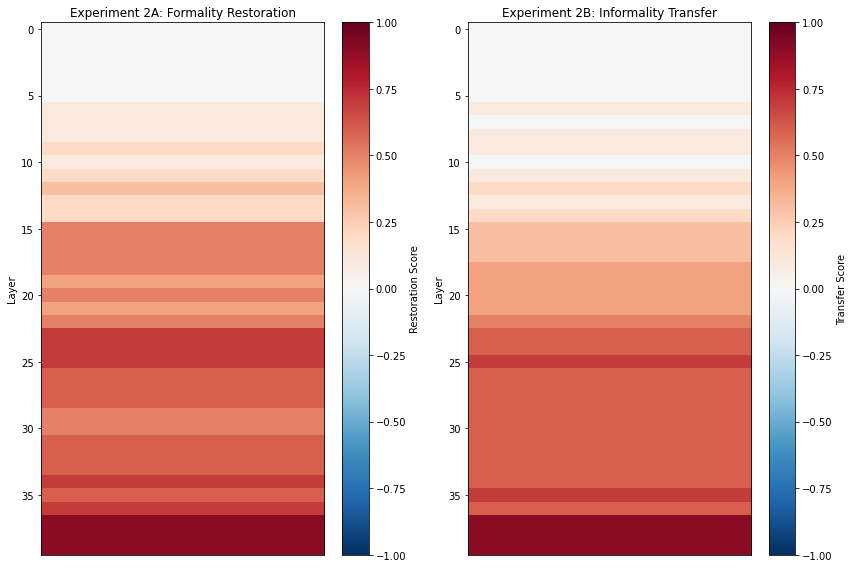

Visualization displayed above


In [60]:
# Simple matplotlib visualization for notebook display
print("Creating visualization with matplotlib...")

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot 2A
im1 = ax1.imshow(results_2a.numpy().reshape(-1, 1), cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Experiment 2A: Formality Restoration')
ax1.set_ylabel('Layer')
ax1.set_yticks(range(0, len(results_2a), 5))
ax1.set_yticklabels(range(0, len(results_2a), 5))
ax1.set_xticks([])

# Plot 2B
im2 = ax2.imshow(results_2b.numpy().reshape(-1, 1), cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax2.set_title('Experiment 2B: Informality Transfer')
ax2.set_ylabel('Layer')
ax2.set_yticks(range(0, len(results_2b), 5))
ax2.set_yticklabels(range(0, len(results_2b), 5))
ax2.set_xticks([])

# Add colorbars
plt.colorbar(im1, ax=ax1, label='Restoration Score')
plt.colorbar(im2, ax=ax2, label='Transfer Score')

plt.tight_layout()
plt.show()

print("Visualization displayed above")

In [61]:
# Print summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

top_2a = results_2a.topk(5)
top_2b = results_2b.topk(5)

print("Top 5 Formality Restoration Layers:")
for i, (score, layer) in enumerate(zip(top_2a.values, top_2a.indices)):
    print(f"  {i+1}. Layer {layer.item():2d}: {score.item():.3f}")

print("\nTop 5 Informality Transfer Layers:")
for i, (score, layer) in enumerate(zip(top_2b.values, top_2b.indices)):
    print(f"  {i+1}. Layer {layer.item():2d}: {score.item():.3f}")

print(f"\nOverall Performance:")
print(f"  Mean certainty restoration: {results_2a.mean().item():.3f}")
print(f"  Mean uncertainty transfer: {results_2b.mean().item():.3f}")
print(f"  Circuit strength ratio: {results_2a.mean().item() / results_2b.mean().item():.2f}x")

# Find high-impact layers
high_2a = (results_2a > 0.5).nonzero(as_tuple=True)[0]
high_2b = (results_2b > 0.5).nonzero(as_tuple=True)[0]
overlap = set(high_2a.tolist()) & set(high_2b.tolist())

print(f"\nHigh-Impact Layer Analysis:")
print(f"  Certainty layers (>0.5): {len(high_2a)}")
print(f"  Uncertainty layers (>0.5): {len(high_2b)}")
print(f"  Overlapping layers: {len(overlap)}")

if overlap:
    print(f"  Shared layers: {sorted(list(overlap))}")

print(f"\nResults saved to: circuit_discovery_results.png")
print("Experiment complete!")


RESULTS SUMMARY
Top 5 Formality Restoration Layers:
  1. Layer 39: 0.900
  2. Layer 37: 0.900
  3. Layer 38: 0.900
  4. Layer 25: 0.700
  5. Layer 24: 0.700

Top 5 Informality Transfer Layers:
  1. Layer 39: 0.900
  2. Layer 37: 0.900
  3. Layer 38: 0.900
  4. Layer 35: 0.700
  5. Layer 25: 0.700

Overall Performance:
  Mean certainty restoration: 0.418
  Mean uncertainty transfer: 0.380
  Circuit strength ratio: 1.10x

High-Impact Layer Analysis:
  Certainty layers (>0.5): 15
  Uncertainty layers (>0.5): 17
  Overlapping layers: 15
  Shared layers: [23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39]

Results saved to: circuit_discovery_results.png
Experiment complete!


In [62]:
results_2a

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.1000, 0.1000,
        0.2000, 0.1000, 0.2000, 0.3000, 0.2000, 0.2000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.7000, 0.7000, 0.7000, 0.6000,
        0.6000, 0.6000, 0.5000, 0.5000, 0.6000, 0.6000, 0.6000, 0.7000, 0.6000,
        0.7000, 0.9000, 0.9000, 0.9000])

In [63]:
results_2b

tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.1000, -0.0000, 0.1000,
        0.1000, -0.0000, 0.1000, 0.2000, 0.1000, 0.2000, 0.3000, 0.3000, 0.3000,
        0.4000, 0.4000, 0.4000, 0.4000, 0.5000, 0.6000, 0.6000, 0.7000, 0.6000,
        0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.7000,
        0.6000, 0.9000, 0.9000, 0.9000])